# 6.5 BatchNorm

### 导入utils中的辅助函数

In [1]:
from utils import *

## 读入猫狗数据

In [2]:
%ls ../dataset/CatDog
%ls ../dataset/CatDog/train
%ls ../dataset/CatDog/validation

train/  validation/
cats/  dogs/
cats/  dogs/


In [3]:
batch_size = 32 # 指定batch_size 
IMSIZE = 128

data_dir = '../dataset/CatDog' # 指定图片路径

# 将读入的图片resize后，转换成tensor
transform = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)), 
    transforms.ToTensor(), 
])

# 准备dataset，使用torchvision.datasets.ImageFolder读入图片，指定变换形式
train_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'validation'), transform=transform)
# 准备dataloaer

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)  # 进行打乱
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4) 

torch.Size([32, 3, 128, 128])
torch.Size([32])


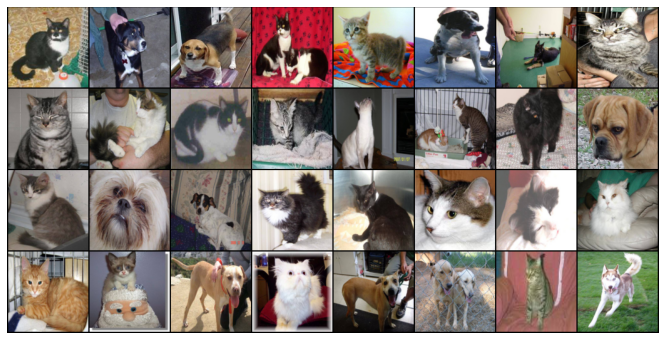

In [4]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 6))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

借助PyTorch内置的nn.Sequential类构建模型。

## 宽模型

In [5]:
class WideModel(nn.Module):
    def __init__(self):
        super(WideModel, self).__init__() 
        # 构建卷积层
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=2),  
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=16))     

        # 构建全连接层 
        self.fc = nn.Sequential(
            nn.Linear(4900, 2)
        )
    # 前向计算流程
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)  ## 在卷积操作后，输出仍是tensor，需要进行flatten拉直，再接全连接层
        out = self.fc(out)
        return out

In [6]:
# 验证模型是否构建正确
def test():
    X = torch.randn((1, 3, IMSIZE, IMSIZE))
    net = WideModel()
    out = net(X)
    print(out.shape)
    
test()

torch.Size([1, 2])


In [7]:
from torchsummary import summary
## 需要预先下载，在终端输入 pip install torchsummary
wide_model = WideModel().cuda()
summary(wide_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 127, 127]           1,300
       BatchNorm2d-2        [-1, 100, 127, 127]             200
              ReLU-3        [-1, 100, 127, 127]               0
         MaxPool2d-4            [-1, 100, 7, 7]               0
            Linear-5                    [-1, 2]           9,802
Total params: 11,302
Trainable params: 11,302
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 36.95
Params size (MB): 0.04
Estimated Total Size (MB): 37.18
----------------------------------------------------------------


## 模型训练

先定义几个训练中会用到的函数。

输入参数epochs和lr，实施训练。

In [8]:
lr = 1e-3
optimizer = torch.optim.Adam(wide_model.parameters(), lr=lr)  # 设置优化器
epochs = 2
history = train(wide_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/2], time: 14.45s, loss: 0.7144, acc: 0.6543, val_loss: 0.5576, val_acc: 0.7218
Epoch [2/2], time: 14.32s, loss: 0.5442, acc: 0.7325, val_loss: 0.5049, val_acc: 0.7543


## 深模型

In [9]:
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__() 
        ## 构建卷积层
        layers = []
        # 建立7层模型，每层结构相同
        for i in range(7):
            in_planes = 3 if i == 0 else 20 # 除了第一层输入为3，其余输入为20（卷积个数）
            layers += [nn.Conv2d(in_planes, 20, kernel_size=2, padding=1),
                                         nn.BatchNorm2d(20), # BN
                                         nn.ReLU(), # 非线性变换
                                         nn.MaxPool2d(kernel_size=2)] #池化
        self.cnn = nn.Sequential(*layers) # 将7层通过nn.Sequential连接起来

        # 构建全连接层 
        self.fc = nn.Sequential(
            nn.Linear(20, 2)
        )
    # 前向计算流程
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)  ## 在卷积操作后，输出仍是tensor，需要进行flatten拉直，再接全连接层
        out = self.fc(out)
        return out

In [10]:
def test():
    X = torch.randn((1, 3, IMSIZE, IMSIZE))
    net = DeepModel()
    out = net(X)
    print(out.shape)
    
test()

torch.Size([1, 2])


In [11]:
deep_model = DeepModel().cuda()
summary(deep_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 129, 129]             260
       BatchNorm2d-2         [-1, 20, 129, 129]              40
              ReLU-3         [-1, 20, 129, 129]               0
         MaxPool2d-4           [-1, 20, 64, 64]               0
            Conv2d-5           [-1, 20, 65, 65]           1,620
       BatchNorm2d-6           [-1, 20, 65, 65]              40
              ReLU-7           [-1, 20, 65, 65]               0
         MaxPool2d-8           [-1, 20, 32, 32]               0
            Conv2d-9           [-1, 20, 33, 33]           1,620
      BatchNorm2d-10           [-1, 20, 33, 33]              40
             ReLU-11           [-1, 20, 33, 33]               0
        MaxPool2d-12           [-1, 20, 16, 16]               0
           Conv2d-13           [-1, 20, 17, 17]           1,620
      BatchNorm2d-14           [-1, 20,

In [12]:
lr = 1e-3
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)  # 设置优化器
history = train(deep_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/2], time: 14.24s, loss: 0.5955, acc: 0.6756, val_loss: 0.5677, val_acc: 0.6980
Epoch [2/2], time: 14.11s, loss: 0.5473, acc: 0.7174, val_loss: 0.5519, val_acc: 0.7118
